<a href="https://colab.research.google.com/github/danny-white/OverlapAnalysis/blob/master/Overlap_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
#    ____                  __               ___                __           _     
#   / __ \_   _____  _____/ /___ _____     /   |  ____  ____ _/ /_  _______(_)____
#  / / / / | / / _ \/ ___/ / __ `/ __ \   / /| | / __ \/ __ `/ / / / / ___/ / ___/
# / /_/ /| |/ /  __/ /  / / /_/ / /_/ /  / ___ |/ / / / /_/ / / /_/ (__  ) (__  ) 
# \____/ |___/\___/_/  /_/\__,_/ .___/  /_/  |_/_/ /_/\__,_/_/\__, /____/_/____/  
#                             /_/                            /____/               

Below you will see the google drive mount code. This allows this program to interact with google drive. Whenever you start a new session you'll need to reauthenticate with google drive, the process is simple, click the link proviced, click on your account, click "allow", then copy the code provided and paste it in the space provided in the cell.

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Next you need to set the input parameters"

0. Before you start ensure the file you want to use is uploaded to the folder linked below in google drive, It should have at least 3 columns, the first being "Access" followed by an increment for each pass 1,2,3... Then col 2 should be pass start time with a format matching either <15 Apr 2020 00:49:37.229> or <4/22/20 22:46>. Extra columns will be ignored. Additionally, a newline and the "header" row with the word "Access" will delimit passes. No more than 6 concurrent passes. 
1.   First select the name of the file in the google drive folder (should be in the format XXX.csv)
2.   Next list the satelleites in the order they are output by STK, you can see an example here: 
``` names = ["RedEye 1", "Sentinal 2A", "Sentinal 2B" ```


Then go to the top toolbar, click runtime -> Run all, on the first run don't forget to authenticate with google drive, then scroll down to find your image. Display Parameters are lower down.



In [0]:
# make sure the file you want to upload is in this folder: ( I have shared it with you so you can just edit it here)
# https://drive.google.com/open?id=1hVFshnqMrPqAKkYqkbg1E3WZ5RgJq5ts

input_filename = "Cop_19_Jan_2021_2.csv"
# Please put in the names of the sats you are using, in the same order they appear in the CSV (starting at the top)
names = [ "RD2", "RD3", "RedEye 1", "Sentinal 2A", "Sentinal 2B"] 



In [0]:
#@title This cell containts parsing code, do not edit
from datetime import datetime
from datetime import timedelta
import numpy as np
import calendar

if len(names) > 6:
	print("error only 6 simultaneous streams supported")

# defaults
months = {v: k for k,v in enumerate(calendar.month_abbr)}
color_names = ["ro-", "go-","bo-","co-","mo-","yo-"]
colors = dict(zip(names, color_names[:len(names)]))
offset = dict(zip(names, range(1, len(names) + 1)))
olap_offset = len(names) + 1
ymax = len(names) + 3
passes = {}
drive_prefix = "/content/drive/My Drive/Shared_Dan_Colab/"
start_buffer, end_buffer = 5,5

def parseDate(strDate):
	l = strDate.split()
	try:
		# format 15 Apr 2020 00:49:37.229
		return datetime(year=int(l[2]), month=months[l[1]], day =int(l[0]), hour = int(l[3].split(":")[0]), minute=int(l[3].split(":")[1]), second=int(float(l[3].split(":")[2])))
	except:
		try:
			# format 4/22/20 22:46
			m,d,y = l[0].split("/")
			try:
				#  time format hh:mm:ss
				h, mi, s = l[1].split(":")
			except:
				#  time format hh:mm (set seconds to 0)
				s = "0"
				h, mi = l[1].split(":")
			return datetime(year=int("20" + y), month = int(m), day = int(d), hour=int(h), minute=int(mi), second=int(s))
		except:
			raise ValueError("bad date format, need either <15 Apr 2020 00:49:37.229> or <4/22/20 22:46> Input line is: "+ l)

# translates a pass from two datetime strings into usable data
def parsePass2(start, end):
	ret = []
	for strDate in [start, end]:
		ret.append(parseDate(strDate))
	# add setup time
	ret[0] -= timedelta(minutes=start_buffer)
	#  add teardown time
	ret[1] += timedelta(minutes=end_buffer)
	return ret

# This uses the inefficient n^2 approach. However datasize is ~500 items so refactoring to nlogn 
# is likely a waste of time
def computeOverlap(passes):
	olap = []
	
	# flattens passes into single list from dictionary 
	flattened_passes = [i for k in passes for i in passes[k]]
	# for each pass iterate over all other passes
	for item in flattened_passes:
			for other in flattened_passes:
				# if passes are the same discard, assumes no two passes have identical start and end times
					if other[0] == item[0] and other[1] == item[1]:
						continue
					else:
						# describe the conflict and if the conflict duration >= 0s then include it in our analysis
						strt = max(other[0], item[0])
						ed = min(other[1], item[1])
						if strt <= ed:
							olap.append([strt, ed])
	
	# this function creates duplicate pairs, so this snippit removes the duplicates
	olap_uniq = []
	for i in olap:
		if i not in olap_uniq:
			olap_uniq.append(i)
	return olap_uniq

#read in data 
nameIdx = 0
with open(drive_prefix +  input_filename) as infile:
	for line in infile:
		name = names[nameIdx]
		# skip header line
		if "Access" in line:
			continue
		# skip blank newline between datasets 
		if line.strip() == "":
			nameIdx += 1
			if nameIdx > len(names):
				raise OverflowError("not enough names in name list, please add more")
			continue
		# skip blank newline between datasets (CSV means an empty line is not blank but ",,,") 
		if not any(line.strip().split(",")):
			nameIdx += 1
			if nameIdx > len(names):
				raise OverflowError("not enough names in name list, please add more")
			continue

		times = [i.strip() for i in line.split(",")]
		try:
			start, end = times[1],times[2]
		except:
			pass
		try:
			passes[name] += [parsePass2(start, end)]
		except:
			passes[name] = [parsePass2(start, end)]


# order is [start_time,end_time], [offset_x, offset_y], color, label
plot_data = []
olap_plot_data = []

#order is annotation, xy, textcords, rotation
annotations_data = []

#plot all pairs
for j in passes:
	toLabel = 1
	color = colors[j]
	for i in passes[j]:
		l = j if toLabel else ""
		toLabel = 0
		lst = [[i[0], i[1]], [offset[j],offset[j]], color, l]
		plot_data.append(lst)

# plot overlap
toLabel = 1
for v in computeOverlap(passes):
	l = "Overlap" if toLabel else ""
	toLabel = 0
	lst = [[v[0], v[1]], [olap_offset, olap_offset], "ko-", l]
	olap_plot_data.append(lst)
	annotations_data.append([str(v[0]) + " + " + str(v[1] - v[0]), (v[0],olap_offset + 0.15),'data', 45]) 




Below are your display parameters, edit as you see fit

1.  Select your start and end times (synax: ```end_time = [YYYY,MM,DD,HH,MM]```, do not prepend with 0's if you want to use month 4 use 4 not 04, additionally for midnight use 0 not 00)
2.  There are some parameters for displaying, ```x_in``` and ```y_in``` roughly correspond to the size of the output image in inches, use this as you see fit (the image will be scaled to fit the display, but if you copy the image and email it it will retain it's original size)

3.   ```grid ``` enables or disables the grid, 1 for grid 0 for no grid

4.   ```annotations ``` enables or disables the overlap time labels, 1 for labels 0 for none

Once you have edited your params then click the play button in the that cell and the display cell.

The image might come out REAALLYY small, just double click and it'll zoom in




In [0]:
# Enter time in the format [YYYY,M,D,H,m] do not prepend with zeros: use 4 instead of 04, use 0 instead of 00
# if you want the whole dataset change to []
start_time = [2021,1,15,0,0]
end_time = [2021,1,30,0,0]

#The image is static, if you don't like the size change these around
x_in, y_in = 80,8

#If you want a grid set this to 1 (default 0)
grid = 1

#If you want annotations set to 1 (default 1)
annotations = 1

num conflicts between start: 2021-01-15 00:00:00 and end: 2021-01-30 00:00:00 = 105


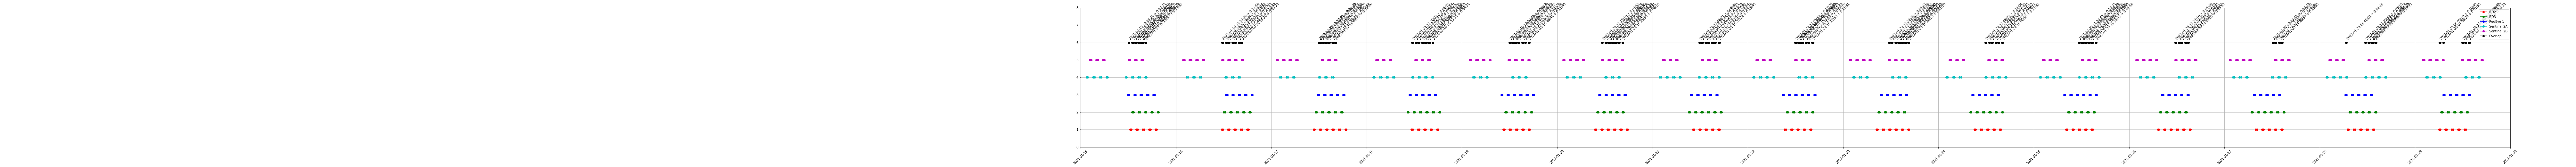

In [0]:
#@title This cell contains display code, do not edit


import matplotlib.ticker as ticker
import matplotlib.pyplot as plt

# flattens passes into single list from dictionary 
flattened_passes = [i for k in passes for i in passes[k]]

#parse time
if start_time and end_time:
	time_start = datetime(start_time[0], start_time[1], start_time[2], start_time[3], start_time[4])
	time_end = datetime(end_time[0], end_time[1], end_time[2], end_time[3], end_time[4])
else:
	# if times are not provided use the first and last times in passes
	time_start = min([i[0] for i in flattened_passes])
	time_end = max([i[1] for i in flattened_passes])

# print num conflicts between start and end time (the disgusting list comprehension just outputs a list of pairs where the start or end of the pair is between time_start and time_end)
print ("num conflicts between start: " + str(time_start) + " and end: " + str(time_end) + " = " + str(len([i for i in olap_plot_data if time_start < i[0][0] < time_end or time_start < i[0][1] < time_end ])))

plt.figure(figsize=(x_in,y_in)) 
# plot passes
for i in plot_data:
  plt.plot(i[0], i[1], i[2], label=i[3])

# plot conflicts
for i in olap_plot_data:
  plt.plot(i[0], i[1], i[2], label=i[3])

# include annotations if needed
if annotations:
  for i in annotations_data:
    plt.gca().annotate(i[0], xy=i[1],textcoords=i[2], rotation=i[3]) 


# Prettify and show
axes = plt.gca()
plt.xticks(rotation=45)
import matplotlib.dates as mdates

# grids daily < 100d
if (time_end - time_start).total_seconds() <= 100 * 24*3600:
	plt.gca().xaxis.set_major_locator(mdates.DayLocator())

#grids hourly less than 2d
if (time_end - time_start).total_seconds() <= 48*3600:
	plt.gca().xaxis.set_major_locator(mdates.HourLocator())
# grids minutely less than 2 hours
if (time_end - time_start).total_seconds() <= 2*3600:
	plt.gca().xaxis.set_major_locator(mdates.MinuteLocator())
axes.set_ylim([0,ymax])
axes.set_xlim([time_start,time_end])
# display legend
axes.legend()
# set grid if needed 
if grid:
	axes.grid()
 
plt.show()